In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/000GithubRepos/SASRec.pytorch')

In [3]:
import time
import torch
import argparse
from model import SASRec
from utils import *

In [4]:
def str2bool(s):
    if s not in {'false', 'true'}:
        raise ValueError('Not a valid boolean string')
    return s == 'true'

In [5]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset', required=True)
    parser.add_argument('--train_dir', required=True)
    parser.add_argument('--batch_size', default=128, type=int)
    parser.add_argument('--lr', default=0.001, type=float)
    parser.add_argument('--maxlen', default=50, type=int)
    parser.add_argument('--hidden_units', default=50, type=int)
    parser.add_argument('--num_blocks', default=2, type=int)
    parser.add_argument('--num_epochs', default=201, type=int)
    parser.add_argument('--num_heads', default=1, type=int)
    parser.add_argument('--dropout_rate', default=0.5, type=float)
    parser.add_argument('--l2_emb', default=0.0, type=float)
    parser.add_argument('--device', default='cpu', type=str)
    parser.add_argument('--inference_only', default=False, type=str2bool)
    parser.add_argument('--state_dict_path', default=None, type=str)
    return parser.parse_args(args=['--dataset', 'ml-1m', '--train_dir', 'default'])
args = get_args()

In [15]:
args.dataset

'ml-1m'

In [16]:
args.train_dir

'default'

In [17]:
[str(k) + ',' + str(v) for k, v in sorted(vars(args).items(), key=lambda x: x[0])]

['batch_size,128',
 'dataset,ml-1m',
 'device,cpu',
 'dropout_rate,0.5',
 'hidden_units,50',
 'inference_only,False',
 'l2_emb,0.0',
 'lr,0.001',
 'maxlen,50',
 'num_blocks,2',
 'num_epochs,201',
 'num_heads,1',
 'state_dict_path,None',
 'train_dir,default']

In [6]:
if not os.path.isdir(args.dataset + '_' + args.train_dir):
    os.makedirs(args.dataset + '_' + args.train_dir)
with open(os.path.join(args.dataset + '_' + args.train_dir, 'args.txt'), 'w') as f:
    f.write('\n'.join([str(k) + ',' + str(v) for k, v in sorted(vars(args).items(), key=lambda x: x[0])]))
f.close()


In [7]:
dataset = data_partition(args.dataset)

In [ ]:
[user_train, user_valid, user_test, usernum, itemnum] = dataset

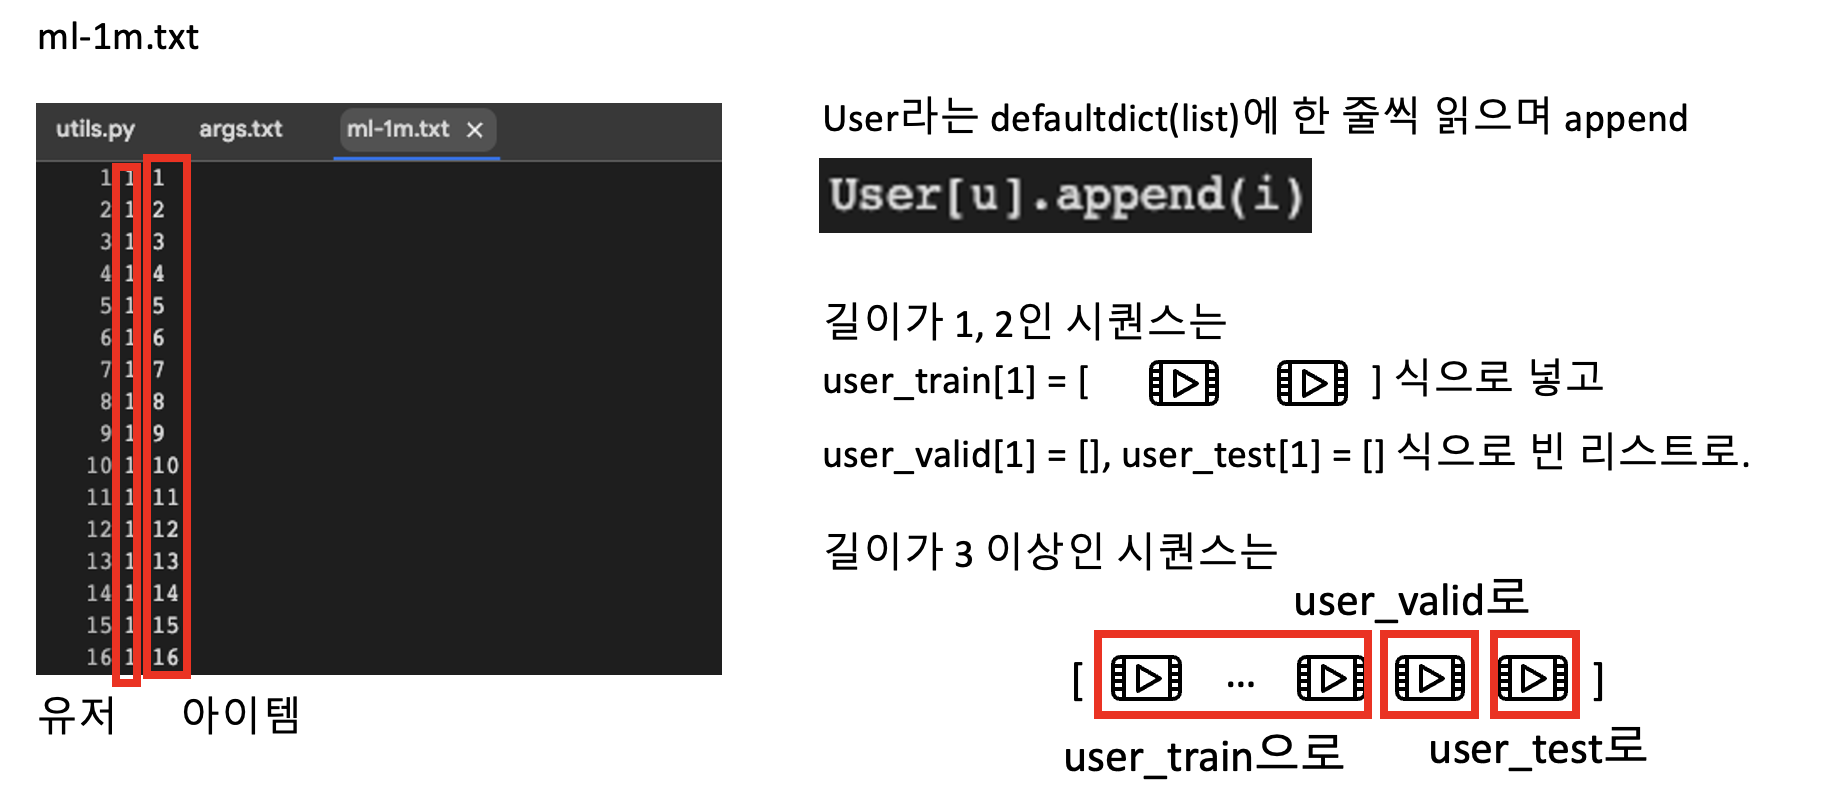

In [18]:
type(user_train)

dict

In [25]:
print(f"유저 최소값 : {min(user_train.keys())}")
print(f"유저 최대값 : {max(user_train.keys()):,}")
print(f"유저 수 : {len(user_train):,}")

유저 최소값 : 1
유저 최대값 : 6,040
유저 수 : 6,040


In [21]:
user_valid[1]

[78]

In [ ]:
num_batch = len(user_train) // args.batch_size # tail? + ((len(user_train) % args.batch_size) != 0)
cc = 0.0
for u in user_train:
    cc += len(user_train[u])

print(f"len(user_train) : {len(user_train)}")
print(f"args.batch_size : {args.batch_size}")
print(f"num_batch : {num_batch}")
print('average sequence length: %.2f' % (cc / len(user_train)))

len(user_train) : 6040
args.batch_size : 128
num_batch : 47
average sequence length: 163.50


In [ ]:
f = open(os.path.join(args.dataset + '_' + args.train_dir, 'log.txt'), 'w')

In [ ]:
sampler = WarpSampler(user_train, usernum, itemnum, batch_size=args.batch_size, maxlen=args.maxlen, n_workers=3)
model = SASRec(usernum, itemnum, args).to(args.device) # no ReLU activation in original SASRec implementation?

In [ ]:
for name, param in model.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass # just ignore those failed init layers

In [ ]:
model.train()

SASRec(
  (item_emb): Embedding(3417, 50, padding_idx=0)
  (pos_emb): Embedding(50, 50)
  (emb_dropout): Dropout(p=0.5, inplace=False)
  (attention_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((50,), eps=1e-08, elementwise_affine=True)
  )
  (attention_layers): ModuleList(
    (0-1): 2 x MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
  )
  (forward_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((50,), eps=1e-08, elementwise_affine=True)
  )
  (forward_layers): ModuleList(
    (0-1): 2 x PointWiseFeedForward(
      (conv1): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
      (dropout1): Dropout(p=0.5, inplace=False)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
      (dropout2): Dropout(p=0.5, inplace=False)
    )
  )
  (last_layernorm): LayerNorm((50,), eps=1e-08, elementwise_affine=True)
)

In [ ]:
epoch_start_idx = 1
if args.state_dict_path is not None:
    try:
        model.load_state_dict(torch.load(args.state_dict_path, map_location=torch.device(args.device)))
        tail = args.state_dict_path[args.state_dict_path.find('epoch=') + 6:]
        epoch_start_idx = int(tail[:tail.find('.')]) + 1
    except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
        print('failed loading state_dicts, pls check file path: ', end="")
        print(args.state_dict_path)
        print('pdb enabled for your quick check, pls type exit() if you do not need it')
        import pdb; pdb.set_trace()

In [ ]:
if args.inference_only:
    model.eval()
    t_test = evaluate(model, dataset, args)
    print('test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))

In [ ]:
# ce_criterion = torch.nn.CrossEntropyLoss()
# https://github.com/NVIDIA/pix2pixHD/issues/9 how could an old bug appear again...
bce_criterion = torch.nn.BCEWithLogitsLoss() # torch.nn.BCELoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.98))

T = 0.0
t0 = time.time()

In [ ]:
u

array([2544, 4861, 5884, 5491, 3860, 2583, 1962, 4370, 4398, 1429, 4336,
        149, 1766, 2768, 5332,  906, 3528, 1520, 3821,  133, 5015, 1085,
       6013, 5014, 2535, 3764, 5965, 4371, 4710, 3254, 1997, 4452, 5141,
       3072, 3730, 2059, 5252, 3569, 2326,  520, 5702, 4258,   20, 4026,
       2377,  935, 5068, 4433, 2920, 4548,  665, 2626, 1936, 3015, 4028,
       1452, 3423, 4327, 4542,  471, 1831, 3695,  501, 1675, 4238, 1419,
        823, 2389,   10, 5878, 2713,  126, 1240, 6032, 3661, 5479, 4649,
       4760,  164, 2017, 2485,  467, 3498, 5979, 1044, 3553, 5753,   20,
       2781, 2427, 5253, 5472, 5373, 3998,  578, 4164, 5905, 3084, 1263,
       4047, 3373, 1075, 4880, 3267,  311,   78, 5236, 2512, 4344,  407,
       2047,  947, 3480, 2017, 1602, 1085, 2041, 1871, 3072, 4692,  781,
       2042, 3463, 3438, 1143, 2477, 5309,  982])

In [ ]:
num_batch

47

In [ ]:
for epoch in range(epoch_start_idx, args.num_epochs + 1):
    if args.inference_only: break # just to decrease identition
    for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
        u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
        u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
        pos_logits, neg_logits = model(u, seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
        # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
        adam_optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = bce_criterion(pos_logits[indices], pos_labels[indices])
        loss += bce_criterion(neg_logits[indices], neg_labels[indices])
        for param in model.item_emb.parameters(): loss += args.l2_emb * torch.norm(param)
        loss.backward()
        adam_optimizer.step()
    print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs

    if epoch % 20 == 0:
        model.eval()
        t1 = time.time() - t0
        T += t1
        print('Evaluating', end='')
        t_test = evaluate(model, dataset, args)
        t_valid = evaluate_valid(model, dataset, args)
        print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f), test (NDCG@10: %.4f, HR@10: %.4f)'
                % (epoch, T, t_valid[0], t_valid[1], t_test[0], t_test[1]))

        f.write(str(t_valid) + ' ' + str(t_test) + '\n')
        f.flush()
        t0 = time.time()
        model.train()

    if epoch == args.num_epochs:
        folder = args.dataset + '_' + args.train_dir
        fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
        fname = fname.format(args.num_epochs, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
        torch.save(model.state_dict(), os.path.join(folder, fname))

loss in epoch 1 iteration 46: 1.0825985670089722
loss in epoch 2 iteration 46: 1.0296783447265625
loss in epoch 3 iteration 46: 0.9918798804283142
loss in epoch 4 iteration 46: 1.0363365411758423
loss in epoch 5 iteration 46: 0.9894118309020996
loss in epoch 6 iteration 46: 0.9223693013191223
loss in epoch 7 iteration 46: 0.9006785154342651
loss in epoch 8 iteration 46: 0.8535668849945068
loss in epoch 9 iteration 46: 0.9186996221542358
loss in epoch 10 iteration 46: 0.8332804441452026
loss in epoch 11 iteration 46: 0.8294389247894287
loss in epoch 12 iteration 46: 0.7924020886421204
loss in epoch 13 iteration 46: 0.789972722530365
loss in epoch 14 iteration 46: 0.7651411294937134
loss in epoch 15 iteration 46: 0.7623987793922424
loss in epoch 16 iteration 46: 0.732724130153656
loss in epoch 17 iteration 46: 0.7201477289199829
loss in epoch 18 iteration 46: 0.6938691139221191
loss in epoch 19 iteration 46: 0.6935722827911377
loss in epoch 20 iteration 46: 0.6927862167358398
Evaluating.